In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the stratified splits
PROCESSED = Path("../../data/processed/month_stratified_splits")

try:
    train_df = pd.read_csv(PROCESSED / "train_data.csv")
    val_df = pd.read_csv(PROCESSED / "val_data.csv")
    test_df = pd.read_csv(PROCESSED / "test_data.csv")
    print("✅ Successfully loaded stratified splits")
except FileNotFoundError:
    print("❌ Split files not found. Please run the data splitting code first.")
    raise

print("Dataset shapes:")
print(f"Training: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")


✅ Successfully loaded stratified splits
Dataset shapes:
Training: (219876, 9)
Validation: (73292, 9)
Test: (73292, 9)


In [2]:
# Prepare features and target (same as Gradient Boosting)
def prepare_features_targets(train_df, val_df, test_df):
    """Prepare features and targets for modeling"""
    
    # Columns to exclude (metadata and target)
    exclude_cols = ['outage_occurred', 'date', 'fips_code', 'month']
    
    # Get feature columns (only those present in all datasets)
    common_cols = set(train_df.columns) & set(val_df.columns) & set(test_df.columns)
    feature_cols = [col for col in common_cols if col not in exclude_cols]
    
    print(f"Using {len(feature_cols)} features:")
    for i, col in enumerate(feature_cols[:10]):  # Show first 10 features
        print(f"  {i+1}. {col}")
    if len(feature_cols) > 10:
        print(f"  ... and {len(feature_cols) - 10} more features")
    
    # Prepare features and targets
    X_train = train_df[feature_cols]
    y_train = train_df['outage_occurred']
    
    X_val = val_df[feature_cols]
    y_val = val_df['outage_occurred']
    
    X_test = test_df[feature_cols]
    y_test = test_df['outage_occurred']
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_cols

X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = prepare_features_targets(train_df, val_df, test_df)


# Check class distribution
print("Class distribution in each set:")
print(f"Training - Outages: {y_train.sum():,} ({y_train.mean():.3%})")
print(f"Validation - Outages: {y_val.sum():,} ({y_val.mean():.3%})")
print(f"Test - Outages: {y_test.sum():,} ({y_test.mean():.3%})")


Using 5 features:
  1. day_of_week
  2. tmin
  3. season
  4. prcp
  5. day_name
Class distribution in each set:
Training - Outages: 20,636 (9.385%)
Validation - Outages: 6,878 (9.384%)
Test - Outages: 6,879 (9.386%)


In [3]:
# Scale features (CRITICAL for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling completed")

✅ Feature scaling completed


In [4]:
# Initialize Logistic Regression model with class weight balancing
print("Training Logistic Regression model...")
lr_model = LogisticRegression(
    C=1.0,                    # Regularization strength
    class_weight='balanced',  # Adjust for class imbalance
    random_state=42,
    max_iter=1000,           # Ensure convergence
    solver='liblinear',       # Good for smaller datasets
    penalty='l2'             # Ridge regularization
)

# Train the model
lr_model.fit(X_train_scaled, y_train)
print("✅ Logistic Regression training completed!")

Training Logistic Regression model...
✅ Logistic Regression training completed!


In [5]:
# Make predictions on all sets
y_train_pred = lr_model.predict(X_train_scaled)
y_train_proba = lr_model.predict_proba(X_train_scaled)[:, 1]

y_val_pred = lr_model.predict(X_val_scaled)
y_val_proba = lr_model.predict_proba(X_val_scaled)[:, 1]

y_test_pred = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    """Comprehensive model evaluation"""
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # Most important for outage prediction
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    # Create metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1_score': f1,
        'roc_auc': roc_auc
    }
    
    # Print results
    print(f"\n{'='*50}")
    print(f"{dataset_name.upper()} SET EVALUATION")
    print(f"{'='*50}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Recall:    {recall:.4f}  ← Most important for outage prediction")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    # Class distribution
    print(f"\nClass Distribution:")
    print(f"Class 0 (No Outage): {np.sum(y_true == 0):,} samples")
    print(f"Class 1 (Outage):    {np.sum(y_true == 1):,} samples")
    print(f"Outage Rate: {(np.sum(y_true == 1) / len(y_true)):.3f}")
    
    return metrics

# Evaluate on all datasets
print("LOGISTIC REGRESSION MODEL PERFORMANCE")
print("=" * 60)
train_metrics = evaluate_model(y_train, y_train_pred, y_train_proba, "training")
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, "validation")
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "test")


LOGISTIC REGRESSION MODEL PERFORMANCE

TRAINING SET EVALUATION
Accuracy:  0.6551
Recall:    0.6854  ← Most important for outage prediction
Precision: 0.1694
F1-Score:  0.2717
ROC-AUC:   0.7262

Class Distribution:
Class 0 (No Outage): 199,240 samples
Class 1 (Outage):    20,636 samples
Outage Rate: 0.094

VALIDATION SET EVALUATION
Accuracy:  0.6559
Recall:    0.6807  ← Most important for outage prediction
Precision: 0.1690
F1-Score:  0.2708
ROC-AUC:   0.7261

Class Distribution:
Class 0 (No Outage): 66,414 samples
Class 1 (Outage):    6,878 samples
Outage Rate: 0.094

TEST SET EVALUATION
Accuracy:  0.6546
Recall:    0.6808  ← Most important for outage prediction
Precision: 0.1684
F1-Score:  0.2701
ROC-AUC:   0.7256

Class Distribution:
Class 0 (No Outage): 66,413 samples
Class 1 (Outage):    6,879 samples
Outage Rate: 0.094


In [6]:
# Create detailed classification reports
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT - TEST SET")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=['No Outage', 'Outage']))


DETAILED CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

   No Outage       0.95      0.65      0.77     66413
      Outage       0.17      0.68      0.27      6879

    accuracy                           0.65     73292
   macro avg       0.56      0.67      0.52     73292
weighted avg       0.88      0.65      0.73     73292



CONFUSION MATRIX ANALYSIS


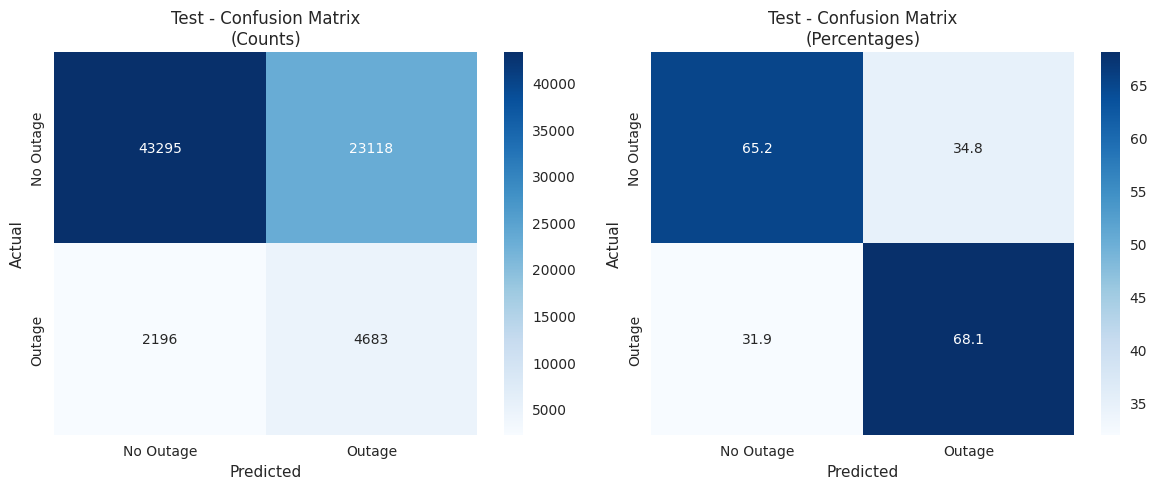


Test Confusion Matrix Insights:
True Negatives (Correct non-outages): 43,295
False Positives (False alarms): 23,118
False Negatives (Missed outages): 2,196 ← Most critical
True Positives (Detected outages): 4,683
Outage Detection Rate: 0.681


In [7]:
# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, dataset_name):
    """Plot confusion matrix with percentages"""
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['No Outage', 'Outage'],
                yticklabels=['No Outage', 'Outage'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title(f'{dataset_name} - Confusion Matrix\n(Counts)')
    
    # Plot percentages
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
                xticklabels=['No Outage', 'Outage'],
                yticklabels=['No Outage', 'Outage'])
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_title(f'{dataset_name} - Confusion Matrix\n(Percentages)')
    
    plt.tight_layout()
    plt.show()
    
    # Print key confusion matrix insights
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{dataset_name} Confusion Matrix Insights:")
    print(f"True Negatives (Correct non-outages): {tn:,}")
    print(f"False Positives (False alarms): {fp:,}")
    print(f"False Negatives (Missed outages): {fn:,} ← Most critical")
    print(f"True Positives (Detected outages): {tp:,}")
    print(f"Outage Detection Rate: {tp/(tp+fn):.3f}")
    
    return cm

# Plot confusion matrices for all sets
print("CONFUSION MATRIX ANALYSIS")
print("=" * 50)
test_cm = plot_confusion_matrix(y_test, y_test_pred, "Test")



ROC-AUC ANALYSIS


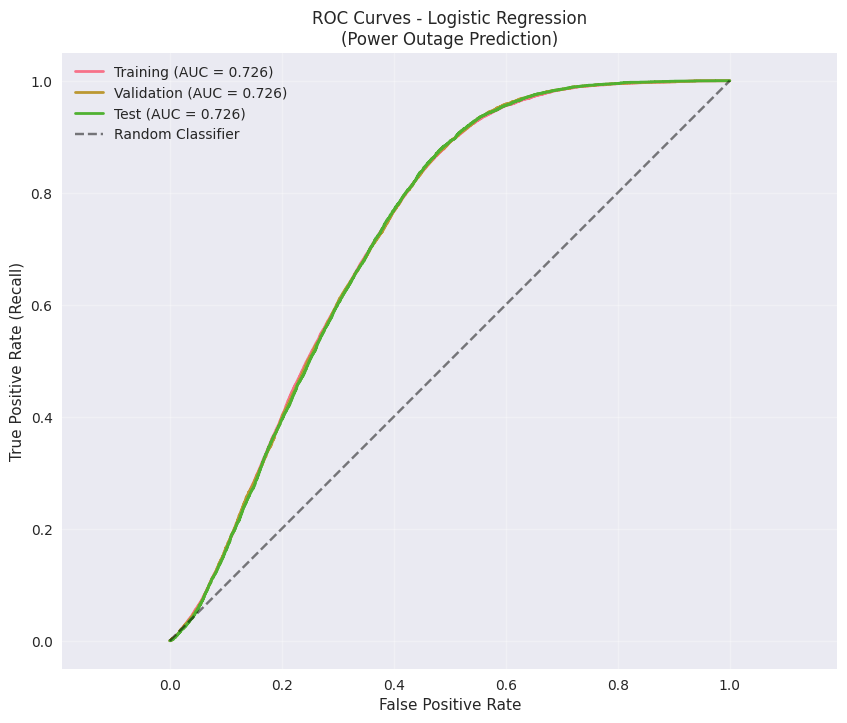

ROC-AUC Scores:
Training:   0.7262
Validation: 0.7261
Test:       0.7256


In [8]:
# ROC Curve Analysis
def plot_roc_curves(y_train_true, y_train_proba, y_val_true, y_val_proba, y_test_true, y_test_proba):
    """Plot ROC curves for all datasets"""
    plt.figure(figsize=(10, 8))
    
    # Calculate ROC curves
    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val_true, y_val_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_proba)
    
    # Calculate AUC scores
    auc_train = roc_auc_score(y_train_true, y_train_proba)
    auc_val = roc_auc_score(y_val_true, y_val_proba)
    auc_test = roc_auc_score(y_test_true, y_test_proba)
    
    # Plot ROC curves
    plt.plot(fpr_train, tpr_train, label=f'Training (AUC = {auc_train:.3f})', linewidth=2)
    plt.plot(fpr_val, tpr_val, label=f'Validation (AUC = {auc_val:.3f})', linewidth=2)
    plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.3f})', linewidth=2)
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curves - Logistic Regression\n(Power Outage Prediction)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()
    
    print(f"ROC-AUC Scores:")
    print(f"Training:   {auc_train:.4f}")
    print(f"Validation: {auc_val:.4f}")
    print(f"Test:       {auc_test:.4f}")
    
    return {
        'train': (fpr_train, tpr_train, auc_train),
        'val': (fpr_val, tpr_val, auc_val),
        'test': (fpr_test, tpr_test, auc_test)
    }

# Plot ROC curves
print("\nROC-AUC ANALYSIS")
print("=" * 40)
roc_data = plot_roc_curves(y_train, y_train_proba, y_val, y_val_proba, y_test, y_test_proba)



FEATURE COEFFICIENT ANALYSIS


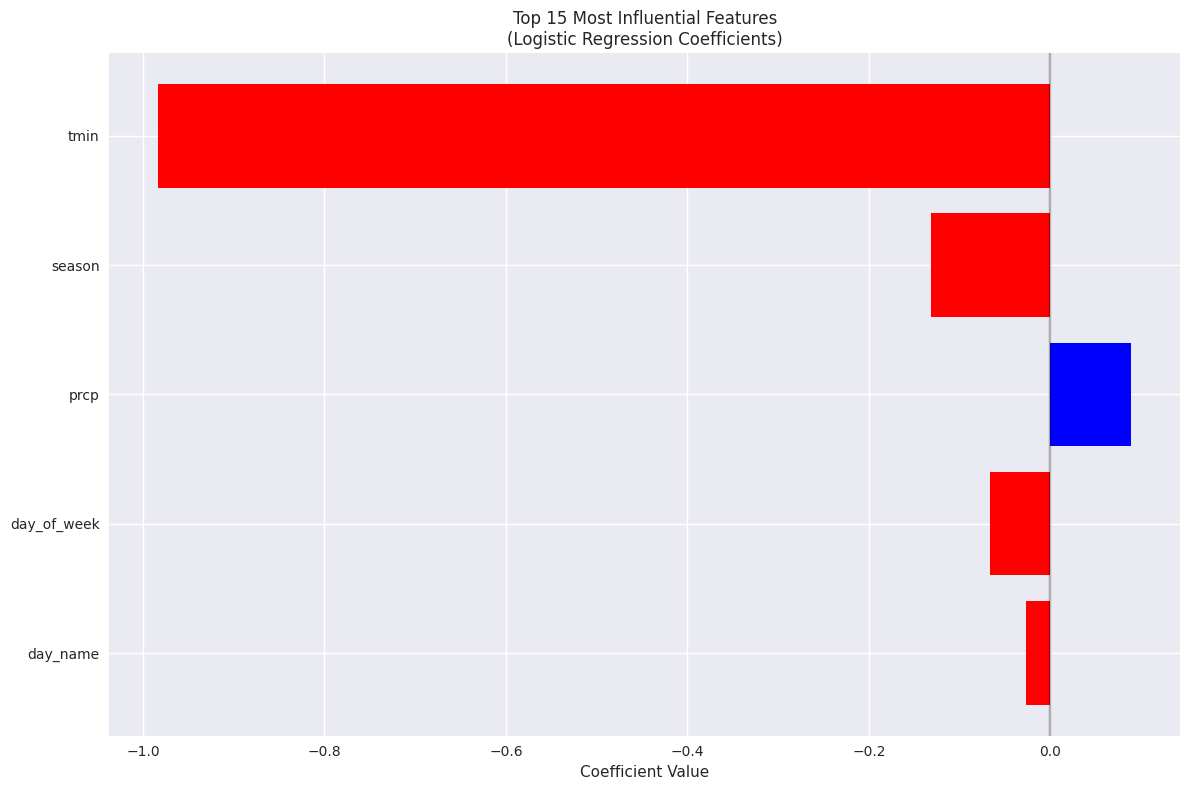


Top 15 Most Influential Features:
Positive coefficients → Higher outage probability
Negative coefficients → Lower outage probability
    feature  coefficient  abs_coefficient
       tmin    -0.983348         0.983348
     season    -0.131041         0.131041
       prcp     0.089217         0.089217
day_of_week    -0.066111         0.066111
   day_name    -0.026692         0.026692


In [9]:
# Feature Coefficient Analysis (Logistic Regression equivalent of Feature Importance)
def plot_feature_coefficients(model, feature_names, top_n=15):
    """Plot feature coefficients for Logistic Regression"""
    coefficients = model.coef_[0]
    
    # Create coefficient dataframe
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients)
    }).sort_values('abs_coefficient', ascending=False)
    
    # Plot top N features by absolute coefficient
    plt.figure(figsize=(12, 8))
    
    top_features = coef_df.head(top_n)
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    
    plt.barh(range(len(top_features)), top_features['coefficient'][::-1], color=colors[::-1])
    plt.yticks(range(len(top_features)), top_features['feature'][::-1])
    plt.xlabel('Coefficient Value')
    plt.title(f'Top {top_n} Most Influential Features\n(Logistic Regression Coefficients)')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop {top_n} Most Influential Features:")
    print("Positive coefficients → Higher outage probability")
    print("Negative coefficients → Lower outage probability")
    print(top_features.head(top_n).to_string(index=False))
    
    return coef_df

# Plot feature coefficients
print("\nFEATURE COEFFICIENT ANALYSIS")
print("=" * 45)
feature_coef_df = plot_feature_coefficients(lr_model, feature_cols, top_n=15)



THRESHOLD OPTIMIZATION ANALYSIS


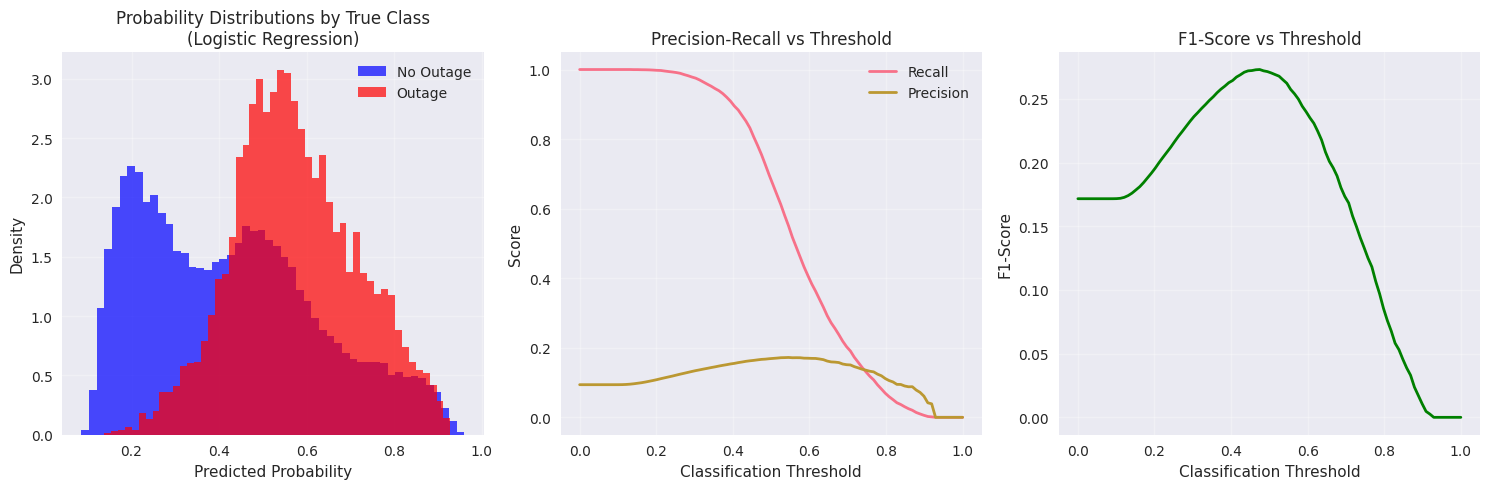

Optimal threshold (max F1): 0.475
F1-score at optimal threshold: 0.273
Recall at optimal threshold: 0.756
Precision at optimal threshold: 0.167


In [10]:
# Probability Distribution and Threshold Analysis
def plot_probability_distributions(y_test_true, y_test_proba, model_name="Logistic Regression"):
    """Plot probability distributions for both classes"""
    plt.figure(figsize=(15, 5))
    
    # Probability distributions
    plt.subplot(1, 3, 1)
    plt.hist(y_test_proba[y_test_true == 0], bins=50, alpha=0.7, 
             label='No Outage', color='blue', density=True)
    plt.hist(y_test_proba[y_test_true == 1], bins=50, alpha=0.7, 
             label='Outage', color='red', density=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title(f'Probability Distributions by True Class\n({model_name})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Precision-Recall tradeoff at different thresholds
    plt.subplot(1, 3, 2)
    thresholds = np.linspace(0, 1, 100)
    recalls = []
    precisions = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_test_proba >= thresh).astype(int)
        recalls.append(recall_score(y_test_true, y_pred_thresh))
        precisions.append(precision_score(y_test_true, y_pred_thresh))
    
    plt.plot(thresholds, recalls, label='Recall', linewidth=2)
    plt.plot(thresholds, precisions, label='Precision', linewidth=2)
    plt.xlabel('Classification Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # F1-score vs threshold
    plt.subplot(1, 3, 3)
    f1_scores = []
    for thresh in thresholds:
        y_pred_thresh = (y_test_proba >= thresh).astype(int)
        f1_scores.append(f1_score(y_test_true, y_pred_thresh))
    
    plt.plot(thresholds, f1_scores, label='F1-Score', linewidth=2, color='green')
    plt.xlabel('Classification Threshold')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Threshold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal threshold (maximizing F1-score)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"Optimal threshold (max F1): {optimal_threshold:.3f}")
    print(f"F1-score at optimal threshold: {f1_scores[optimal_idx]:.3f}")
    print(f"Recall at optimal threshold: {recalls[optimal_idx]:.3f}")
    print(f"Precision at optimal threshold: {precisions[optimal_idx]:.3f}")
    
    return optimal_threshold, recalls[optimal_idx], precisions[optimal_idx], f1_scores[optimal_idx]

# Plot probability analysis
print("\nTHRESHOLD OPTIMIZATION ANALYSIS")
print("=" * 45)
optimal_threshold, opt_recall, opt_precision, opt_f1 = plot_probability_distributions(y_test, y_test_proba, "Logistic Regression")

In [11]:
# Evaluate with optimal threshold
y_test_optimal = (y_test_proba >= optimal_threshold).astype(int)

print("\n" + "="*60)
print("PERFORMANCE AT OPTIMAL THRESHOLD (Max F1)")
print("="*60)
print(f"Threshold: {optimal_threshold:.3f}")

optimal_metrics = evaluate_model(y_test, y_test_optimal, y_test_proba, "Test (Optimal Threshold)")

# Compare with default threshold performance
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION COMPARISON")
print("="*70)
print(f"{'Metric':<15} {'Default (0.5)':<12} {'Optimal':<12} {'Improvement':<12}")
print(f"{'-'*70}")
print(f"{'Accuracy':<15} {test_metrics['accuracy']:.4f}      {optimal_metrics['accuracy']:.4f}      {optimal_metrics['accuracy'] - test_metrics['accuracy']:+.4f}")
print(f"{'Recall':<15} {test_metrics['recall']:.4f}      {optimal_metrics['recall']:.4f}      {optimal_metrics['recall'] - test_metrics['recall']:+.4f}")
print(f"{'Precision':<15} {test_metrics['precision']:.4f}      {optimal_metrics['precision']:.4f}      {optimal_metrics['precision'] - test_metrics['precision']:+.4f}")
print(f"{'F1-Score':<15} {test_metrics['f1_score']:.4f}      {optimal_metrics['f1_score']:.4f}      {optimal_metrics['f1_score'] - test_metrics['f1_score']:+.4f}")



PERFORMANCE AT OPTIMAL THRESHOLD (Max F1)
Threshold: 0.475

TEST (OPTIMAL THRESHOLD) SET EVALUATION
Accuracy:  0.6223
Recall:    0.7556  ← Most important for outage prediction
Precision: 0.1666
F1-Score:  0.2730
ROC-AUC:   0.7256

Class Distribution:
Class 0 (No Outage): 66,413 samples
Class 1 (Outage):    6,879 samples
Outage Rate: 0.094

THRESHOLD OPTIMIZATION COMPARISON
Metric          Default (0.5) Optimal      Improvement 
----------------------------------------------------------------------
Accuracy        0.6546      0.6223      -0.0323
Recall          0.6808      0.7556      +0.0749
Precision       0.1684      0.1666      -0.0018
F1-Score        0.2701      0.2730      +0.0030


In [12]:
# Model Comparison with Gradient Boosting (if available)
def load_gb_metrics():
    """Load Gradient Boosting metrics for comparison"""
    try:
        gb_metrics_path = Path("../../models/gradient_boosting/model_metrics.csv")
        if gb_metrics_path.exists():
            gb_metrics = pd.read_csv(gb_metrics_path)
            gb_test_metrics = gb_metrics[gb_metrics['dataset'] == 'test'].iloc[0]
            return gb_test_metrics
    except:
        pass
    return None

gb_metrics = load_gb_metrics()

if gb_metrics is not None:
    print("\n" + "="*70)
    print("MODEL COMPARISON: LOGISTIC REGRESSION vs GRADIENT BOOSTING")
    print("="*70)
    print(f"{'Metric':<15} {'Logistic Regression':<20} {'Gradient Boosting':<20} {'Difference':<12}")
    print(f"{'-'*70}")
    print(f"{'Accuracy':<15} {test_metrics['accuracy']:.4f}             {gb_metrics['accuracy']:.4f}              {test_metrics['accuracy'] - gb_metrics['accuracy']:+.4f}")
    print(f"{'Recall':<15} {test_metrics['recall']:.4f}             {gb_metrics['recall']:.4f}              {test_metrics['recall'] - gb_metrics['recall']:+.4f}")
    print(f"{'Precision':<15} {test_metrics['precision']:.4f}             {gb_metrics['precision']:.4f}              {test_metrics['precision'] - gb_metrics['precision']:+.4f}")
    print(f"{'F1-Score':<15} {test_metrics['f1_score']:.4f}             {gb_metrics['f1_score']:.4f}              {test_metrics['f1_score'] - gb_metrics['f1_score']:+.4f}")
    print(f"{'ROC-AUC':<15} {test_metrics['roc_auc']:.4f}             {gb_metrics['roc_auc']:.4f}              {test_metrics['roc_auc'] - gb_metrics['roc_auc']:+.4f}")



MODEL COMPARISON: LOGISTIC REGRESSION vs GRADIENT BOOSTING
Metric          Logistic Regression  Gradient Boosting    Difference  
----------------------------------------------------------------------
Accuracy        0.6546             0.9127              -0.2580
Recall          0.6808             0.2247              +0.4560
Precision       0.1684             0.5912              -0.4228
F1-Score        0.2701             0.3257              -0.0556
ROC-AUC         0.7256             0.9064              -0.1809


In [13]:
# Save model and results OPTIONAL
def save_model_and_results(model, scaler, metrics, feature_coef, output_dir):
    """Save model, scaler, and evaluation results"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save model
    joblib.dump(model, output_dir / "logistic_regression_model.pkl")
    joblib.dump(scaler, output_dir / "feature_scaler.pkl")
    
    # Save metrics
    metrics_df = pd.DataFrame({
        'dataset': ['training', 'validation', 'test'],
        'accuracy': [metrics['train']['accuracy'], metrics['val']['accuracy'], metrics['test']['accuracy']],
        'recall': [metrics['train']['recall'], metrics['val']['recall'], metrics['test']['recall']],
        'precision': [metrics['train']['precision'], metrics['val']['precision'], metrics['test']['precision']],
        'f1_score': [metrics['train']['f1_score'], metrics['val']['f1_score'], metrics['test']['f1_score']],
        'roc_auc': [metrics['train']['roc_auc'], metrics['val']['roc_auc'], metrics['test']['roc_auc']]
    })
    metrics_df.to_csv(output_dir / "model_metrics.csv", index=False)
    
    # Save feature coefficients
    feature_coef.to_csv(output_dir / "feature_coefficients.csv", index=False)
    
    # Save configuration
    config = {
        'model_type': 'LogisticRegression',
        'feature_count': len(feature_cols),
        'optimal_threshold': float(optimal_threshold),
        'training_samples': len(y_train),
        'test_samples': len(y_test),
        'model_parameters': {
            'C': 1.0,
            'class_weight': 'balanced',
            'solver': 'liblinear',
            'penalty': 'l2',
            'max_iter': 1000
        }
    }
    
    with open(output_dir / "model_config.json", 'w') as f:
        json.dump(config, f, indent=2)
    
    print(f"\n✅ Logistic Regression model and results saved to: {output_dir}")

# Save everything
MODELS_DIR = Path("../../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

save_model_and_results(
    lr_model, 
    scaler, 
    {'train': train_metrics, 'val': val_metrics, 'test': test_metrics},
    feature_coef_df,
    MODELS_DIR / "logistic_regression"
)


✅ Logistic Regression model and results saved to: ../../models/logistic_regression


In [14]:
# Final Summary
print("\n" + "="*70)
print("LOGISTIC REGRESSION MODEL - FINAL SUMMARY")
print("="*70)
print(f"🎯 Test Set Recall (Outage Detection): {test_metrics['recall']:.3f}")
print(f"📊 Test Set ROC-AUC: {test_metrics['roc_auc']:.3f}")
print(f"🎯 Test Set F1-Score: {test_metrics['f1_score']:.3f}")
print(f"📈 Test Set Accuracy: {test_metrics['accuracy']:.3f}")
print(f"⚡ Optimal threshold for outage prediction: {optimal_threshold:.3f}")

print(f"\n🎯 With Optimal Threshold ({optimal_threshold:.3f}):")
print(f"   - Recall: {optimal_metrics['recall']:.3f} (Detects {optimal_metrics['recall']:.1%} of outages)")
print(f"   - Precision: {optimal_metrics['precision']:.3f} ({optimal_metrics['precision']:.1%} of predictions are correct)")
print(f"   - F1-Score: {optimal_metrics['f1_score']:.3f}")

# Compare with baseline (predicting all zeros)
baseline_accuracy = np.mean(y_test == 0)
print(f"\nBaseline (predict no outage): {baseline_accuracy:.3f}")
print(f"Model improvement over baseline: {test_metrics['accuracy'] - baseline_accuracy:.3f}")

print(f"\nKey Insights:")
print(f"- Logistic Regression achieves ROC-AUC of {test_metrics['roc_auc']:.3f}")
print(f"- With optimal threshold, detects {optimal_metrics['recall']:.1%} of outages")
print(f"- {test_cm[1,1]:,} outages correctly detected, {test_cm[1,0]:,} outages missed")

if gb_metrics is not None:
    print(f"\nComparison with Gradient Boosting:")
    print(f"- ROC-AUC difference: {test_metrics['roc_auc'] - gb_metrics['roc_auc']:+.3f}")
    print(f"- Recall difference: {test_metrics['recall'] - gb_metrics['recall']:+.3f}")

# %%
# Load and display saved metrics to verify
try:
    saved_metrics = pd.read_csv(MODELS_DIR / "logistic_regression" / "model_metrics.csv")
    print("\n✅ Saved Metrics Verification:")
    print(saved_metrics.to_string(index=False))
except:
    print("Could not load saved metrics for verification")


LOGISTIC REGRESSION MODEL - FINAL SUMMARY
🎯 Test Set Recall (Outage Detection): 0.681
📊 Test Set ROC-AUC: 0.726
🎯 Test Set F1-Score: 0.270
📈 Test Set Accuracy: 0.655
⚡ Optimal threshold for outage prediction: 0.475

🎯 With Optimal Threshold (0.475):
   - Recall: 0.756 (Detects 75.6% of outages)
   - Precision: 0.167 (16.7% of predictions are correct)
   - F1-Score: 0.273

Baseline (predict no outage): 0.906
Model improvement over baseline: -0.252

Key Insights:
- Logistic Regression achieves ROC-AUC of 0.726
- With optimal threshold, detects 75.6% of outages
- 4,683 outages correctly detected, 2,196 outages missed

Comparison with Gradient Boosting:
- ROC-AUC difference: -0.181
- Recall difference: +0.456

✅ Saved Metrics Verification:
   dataset  accuracy   recall  precision  f1_score  roc_auc
  training  0.655056 0.685404   0.169395  0.271653 0.726235
validation  0.655924 0.680721   0.169001  0.270777 0.726092
      test  0.654614 0.680768   0.168447  0.270069 0.725578
